# Redcard Exploratory Data Analysis

This dataset is taken from a fantastic paper that looks to see how analytical choices made by different data science teams on the same dataset in an attempt to answer the same research question affect the final outcome.

[Many analysts, one dataset: Making transparent how variations in analytical choices affect results](https://osf.io/gvm2z/)

The data can be found [here](https://osf.io/47tnc/).



## The Task

Do an Exploratory Data Analysis on the redcard dataset. Keeping in mind the question is the following: **Are soccer referees more likely to give red cards to dark-skin-toned players than light-skin-toned players?**

- Before plotting/joining/doing something, have a question or hypothesis that you want to investigate
- Draw a plot of what you want to see on paper to sketch the idea
- Write it down, then make the plan on how to get there
- How do you know you aren't fooling yourself
- What else can I check if this is actually true?
- What evidence could there be that it's wrong?


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import mpld3
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

# import hdbscan
from sklearn.datasets import make_blobs
import time

## About the Data

> The dataset is available as a list with 146,028 dyads of players and referees and includes details from players, details from referees and details regarding the interactions of player-referees. A summary of the variables of interest can be seen below. A detailed description of all variables included can be seen in the README file on the project website. 

> From a company for sports statistics, we obtained data and profile photos from all soccer players (N = 2,053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3,147) that these players played under in their professional career (see Figure 1). We created a dataset of player–referee dyads including the number of matches players and referees encountered each other and our dependent variable, the number of red cards given to a player by a particular referee throughout all matches the two encountered each other.

> -- https://docs.google.com/document/d/1uCF5wmbcL90qvrk_J27fWAvDcDNrO9o_APkicwRkOKc/edit


| Variable Name: | Variable Description: | 
| -- | -- | 
| playerShort | short player ID | 
| player | player name | 
| club | player club | 
| leagueCountry | country of player club (England, Germany, France, and Spain) | 
| height | player height (in cm) | 
| weight | player weight (in kg) | 
| position | player position | 
| games | number of games in the player-referee dyad | 
| goals | number of goals in the player-referee dyad | 
| yellowCards | number of yellow cards player received from the referee | 
| yellowReds | number of yellow-red cards player received from the referee | 
| redCards | number of red cards player received from the referee | 
| photoID | ID of player photo (if available) | 
| rater1 | skin rating of photo by rater 1 | 
| rater2 | skin rating of photo by rater 2 | 
| refNum | unique referee ID number (referee name removed for anonymizing purposes) | 
| refCountry | unique referee country ID number | 
| meanIAT | mean implicit bias score (using the race IAT) for referee country | 
| nIAT | sample size for race IAT in that particular country | 
| seIAT | standard error for mean estimate of race IAT   | 
| meanExp | mean explicit bias score (using a racial thermometer task) for referee country | 
| nExp | sample size for explicit bias in that particular country | 
| seExp |  standard error for mean estimate of explicit bias measure | 



## Tidy Data

Hadley Wickham's concept of a **tidy dataset** summarized as:

>  - Each variable forms a column
>  - Each observation forms a row
>  - Each type of observational unit forms a table

A longer paper describing this can be found in this [pdf](https://www.jstatsoft.org/article/view/v059i10/v59i10.pdf).

Having datasets in this form allows for much simpler analyses. So the first step is to try and clean up the dataset into a tidy dataset. 

The first step that I am going to take is to break up the dataset into the different observational units. By that I'm going to have separate tables (or dataframes) for: 

 - players
 - clubs
 - referees
 - countries
 - dyads

In [5]:
def save_subgroup(dataframe, g_index, subgroup_name, prefix='../data/redcard/raw_'):
    save_subgroup_filename = "".join([prefix, subgroup_name, ".csv.gz"])
    dataframe.to_csv(save_subgroup_filename, compression='gzip')
    test_df = pd.read_csv(save_subgroup_filename, compression='gzip', index_col=g_index)
    # Test that we recover what we send in
    if dataframe.equals(test_df):
        print("Test-passed: we recover the equivalent subgroup dataframe.")
    else:
        print("Warning -- equivalence test!!! Double-check.")

In [6]:
def load_subgroup(filename, index_col=[0]):
    return pd.read_csv(filename, compression='gzip', index_col=index_col)

## Players

In [45]:
players = load_subgroup("../data/redcard/raw_players.csv.gz")
referees = load_subgroup("../data/redcard/raw_referees.csv.gz")

In [8]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2
playerShort,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25


In [9]:
players.shape

(2053, 7)

## Visualize the missing-ness of data

https://github.com/ResidentMario/missingno

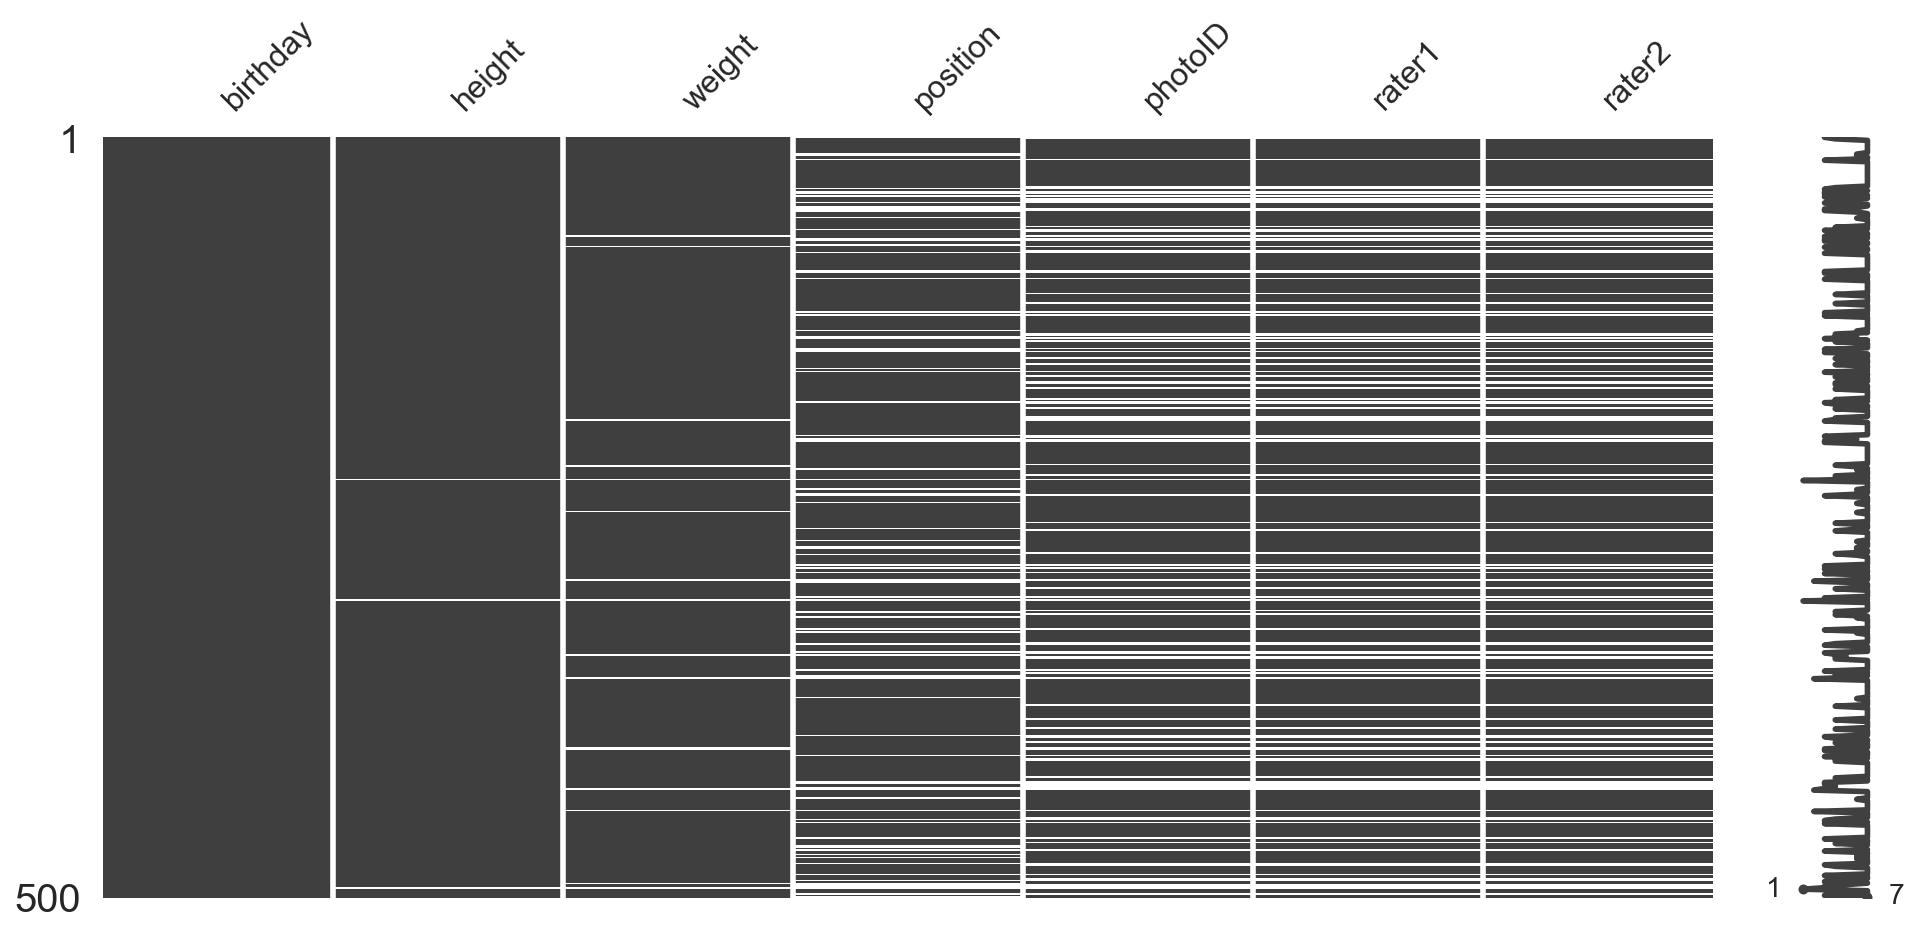

In [10]:
msno.matrix(players.sample(500),
            figsize=(16, 7),
            width_ratios=(15, 1))

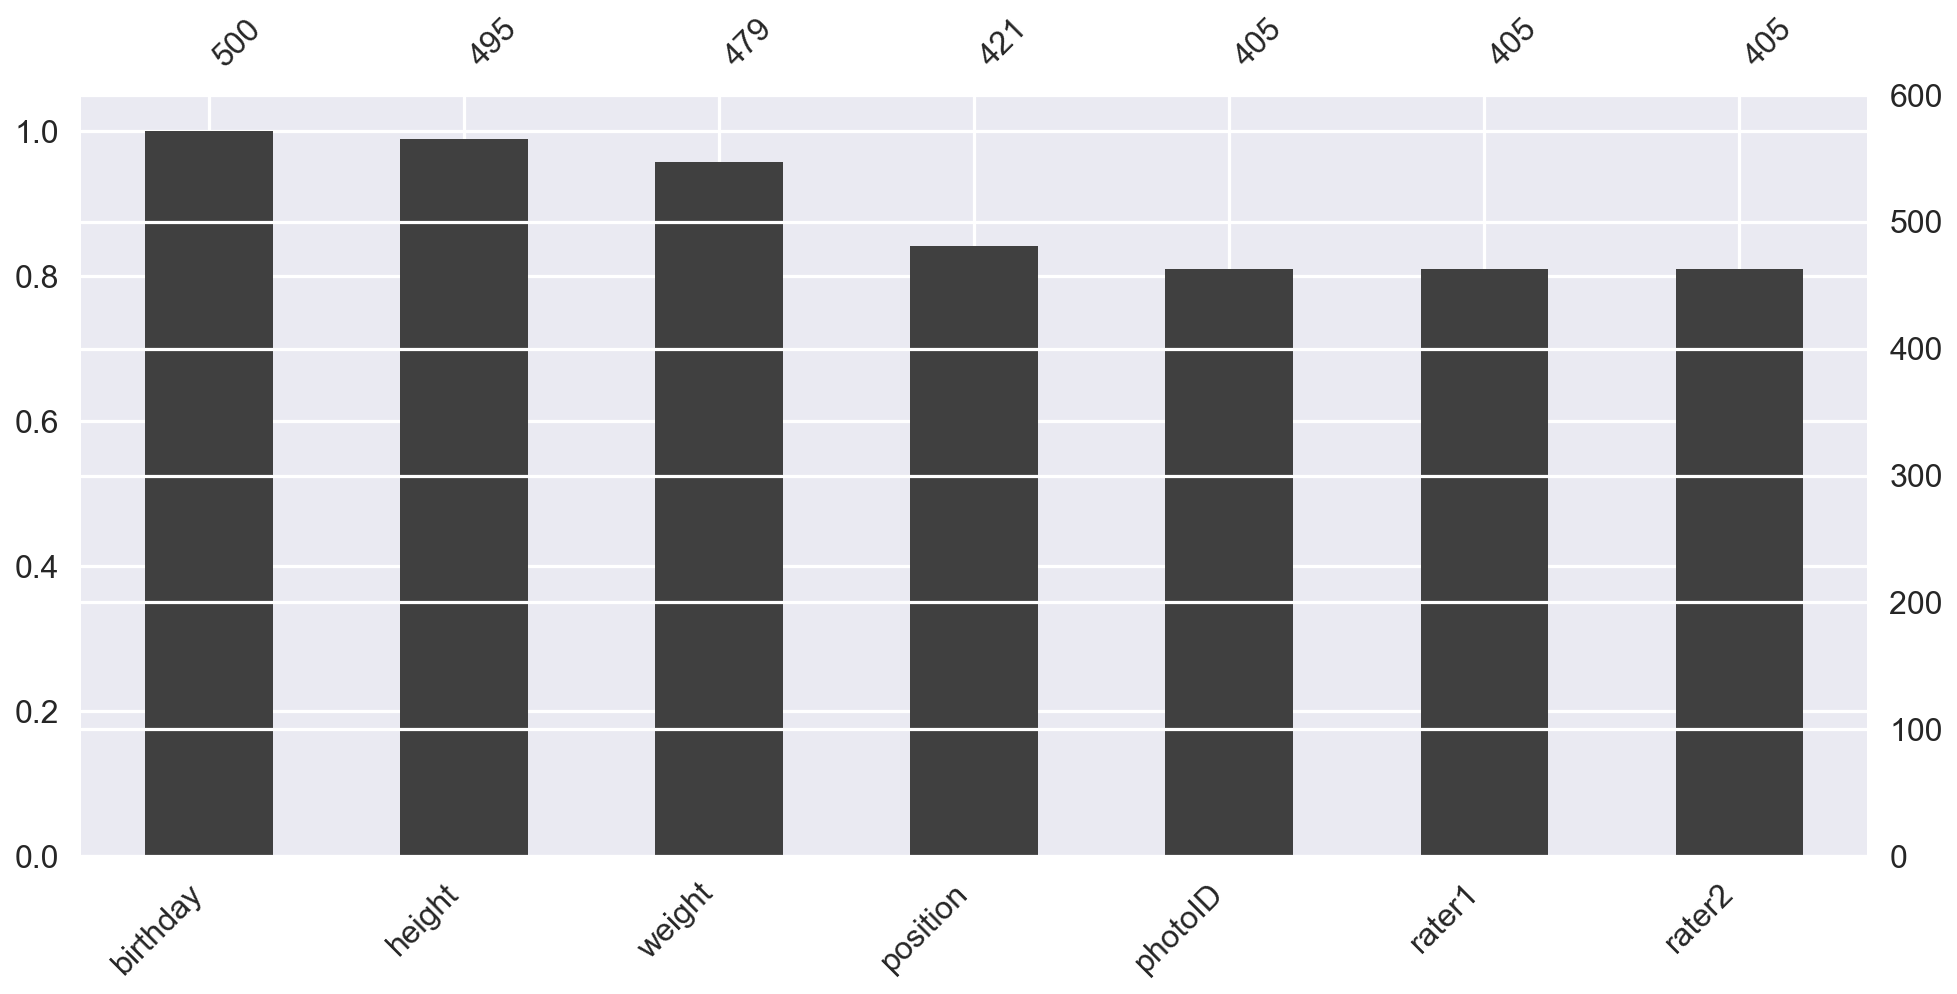

In [11]:
msno.bar(players.sample(500),
            figsize=(16, 7),)

Interesting! It appears that a significant fraction of players don't have a skintone rating from at least one rater. Are they missing in both? Since this is the feature we are supposed to be answering against -- it's an important thing to figure out early! Let's see if there's correlated patterns in how the data is missing for this table: 

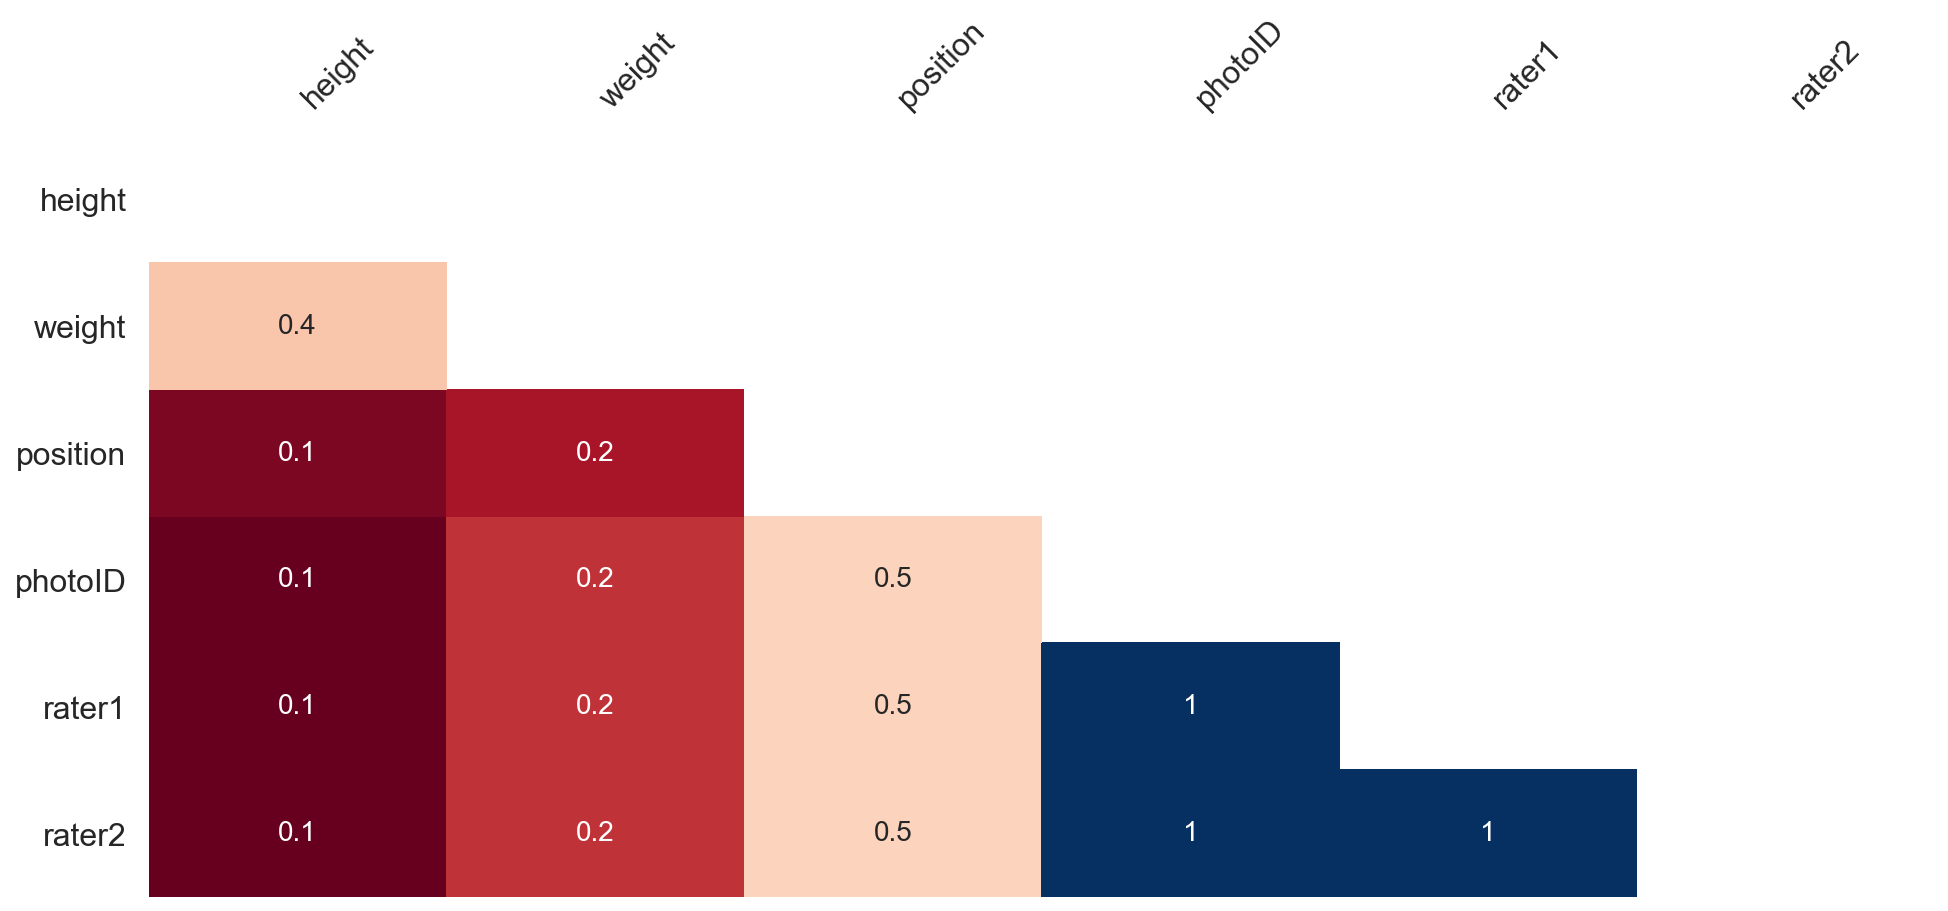

In [12]:
msno.heatmap(players.sample(500),
            figsize=(16, 7),)

In [13]:
print("All players:", len(players))
print("rater1 nulls:", len(players[(players.rater1.isnull())]))
print("rater2 nulls:", len(players[players.rater2.isnull()]))
print("Both nulls:", len(players[(players.rater1.isnull()) & (players.rater2.isnull())]))

All players: 2053
rater1 nulls: 468
rater2 nulls: 468
Both nulls: 468


In [14]:
# modifying dataframe
players = players[players.rater1.notnull()]
players.shape[0]

1585

In [15]:
2053-1585

468

We've removed 468 players from the table who had no skintone rating.

Let's look again at the missing data in this table. 

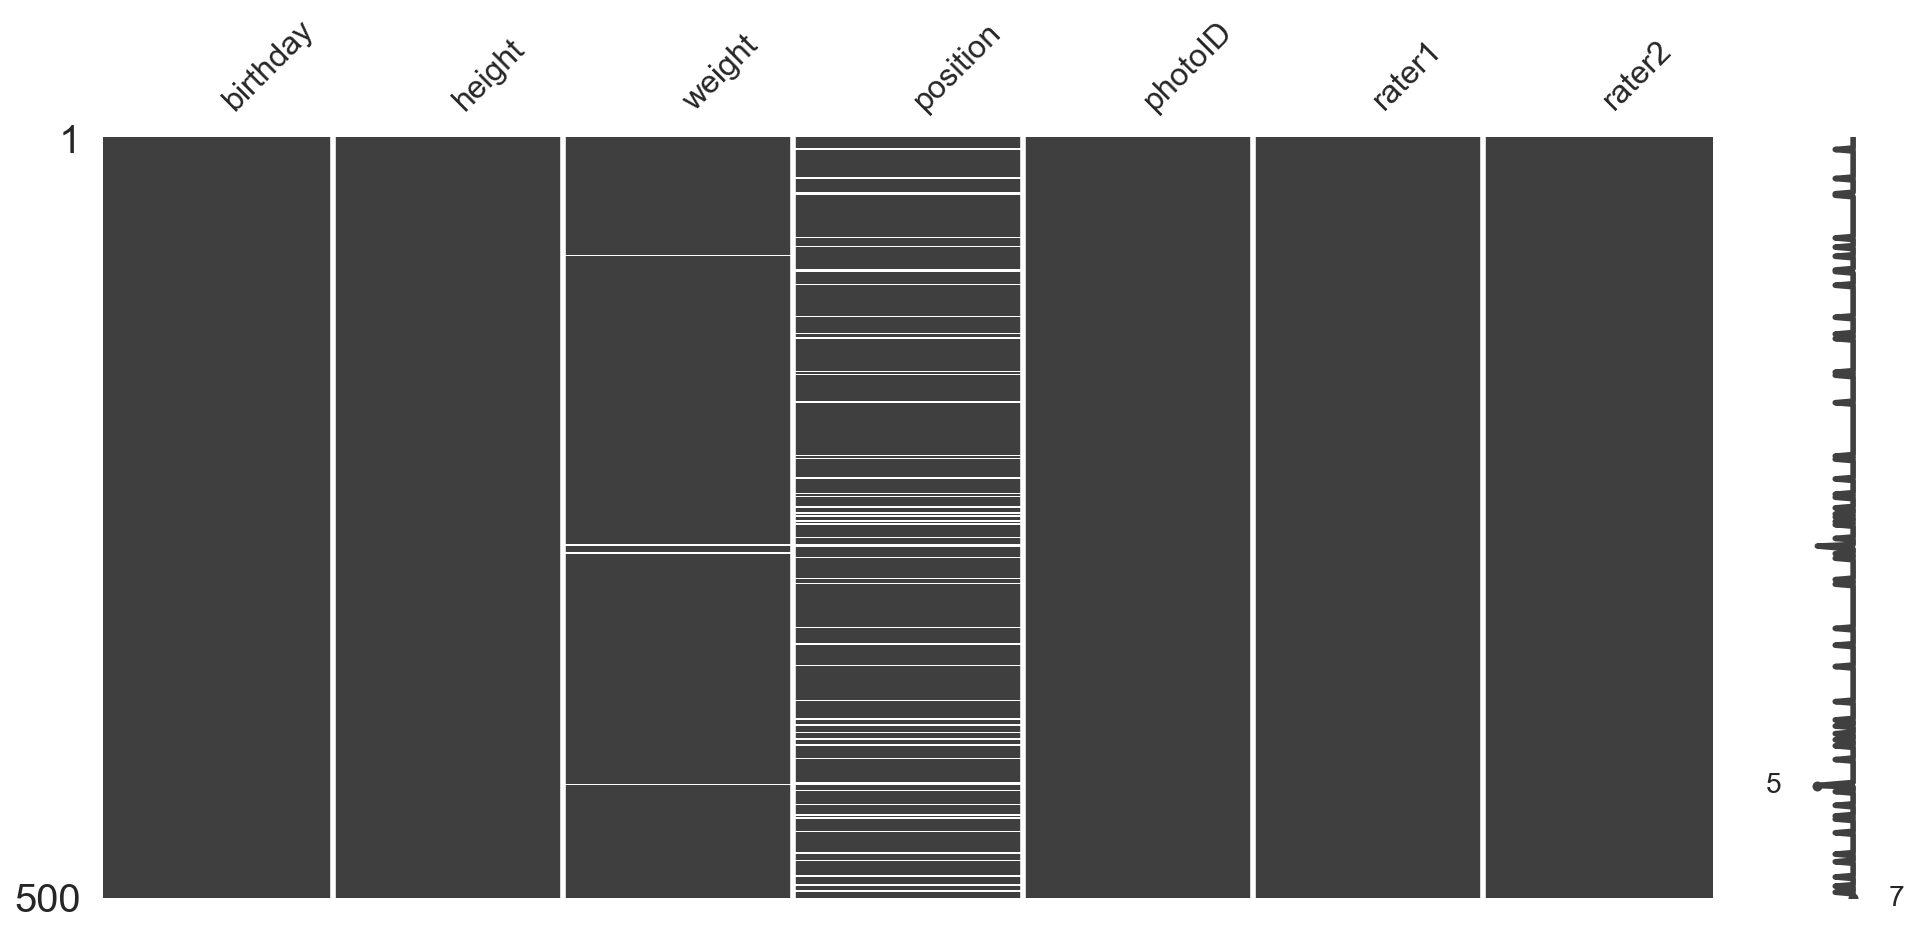

In [16]:
msno.matrix(players.sample(500),
            figsize=(16, 7),
            width_ratios=(15, 1))

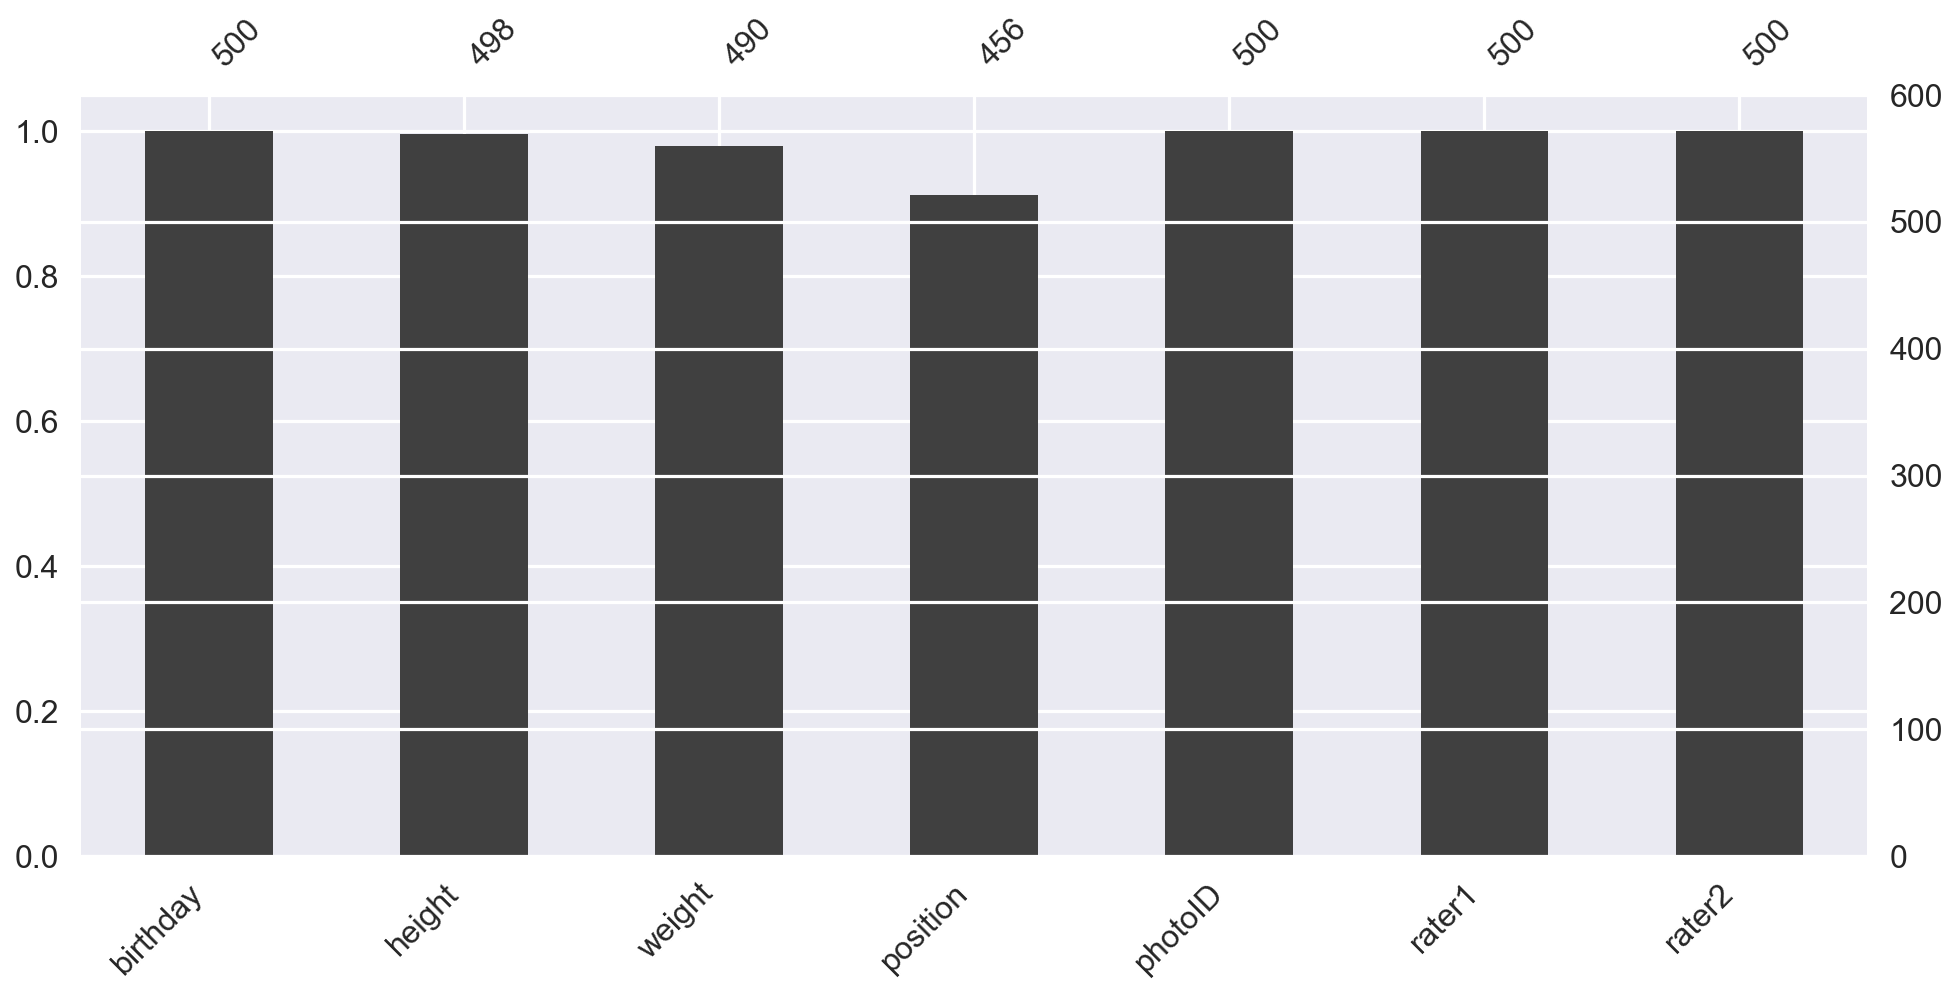

In [17]:
msno.bar(players.sample(500),
            figsize=(16, 7),)

Each remaining player in the table has 2 skintone ratings -- are they sufficiently close that they can be combined?

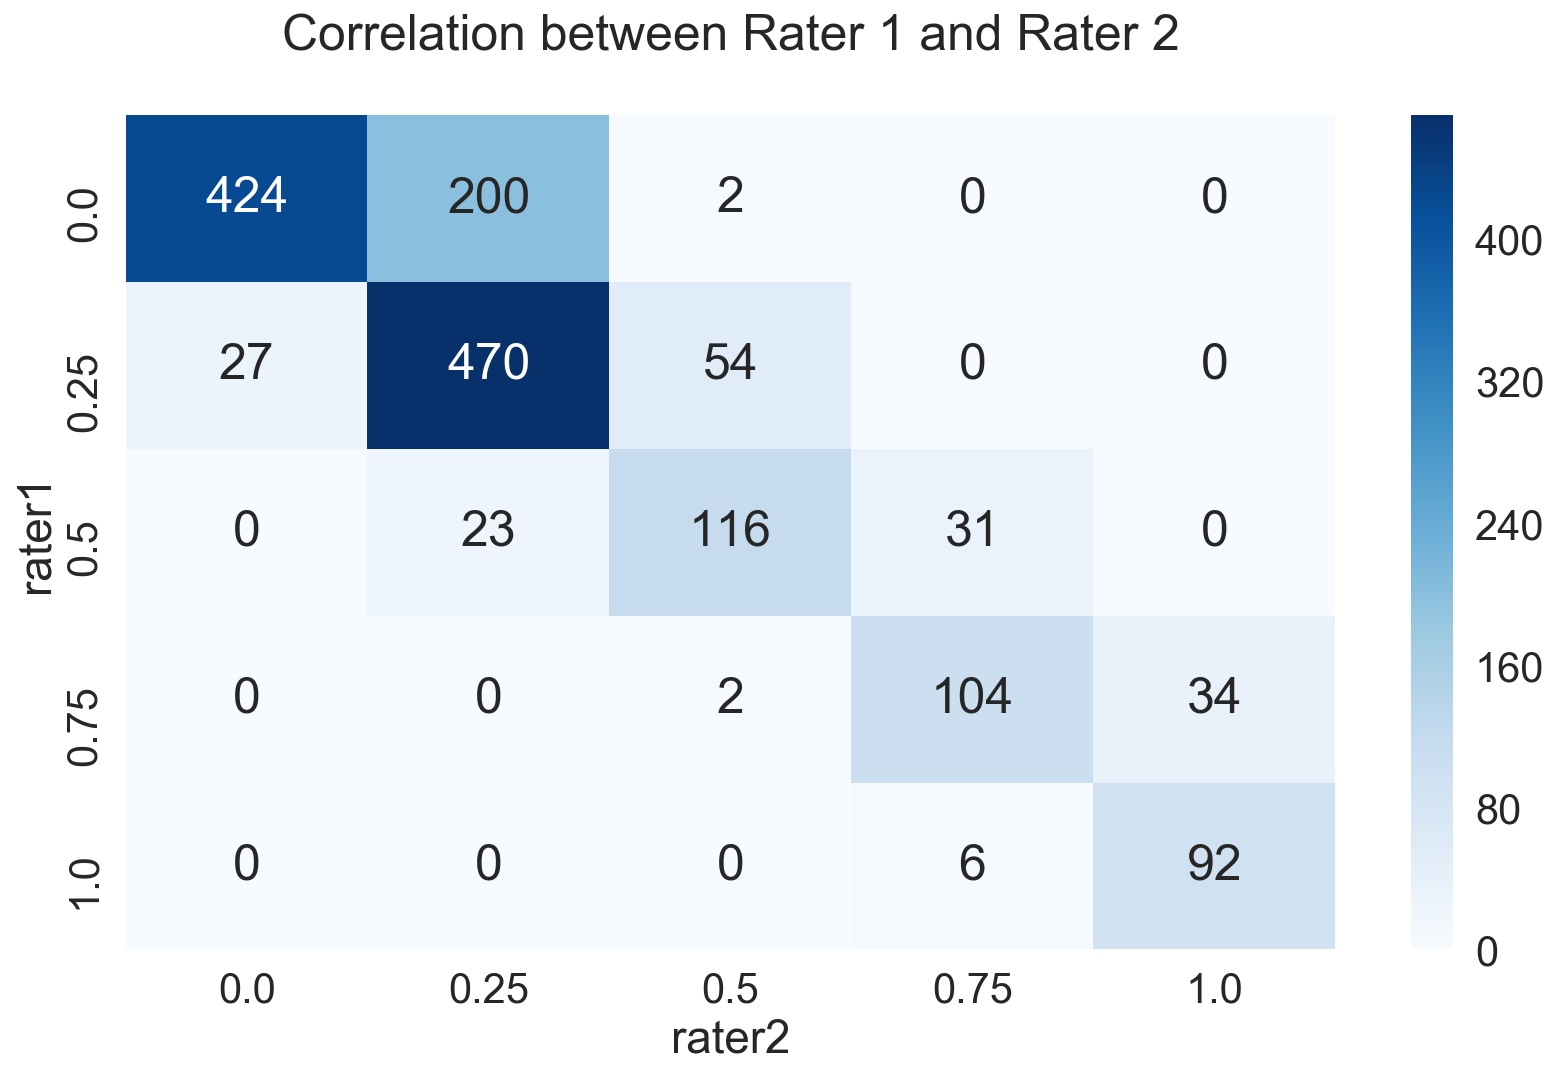

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap='Blues', annot=True, fmt='d', ax=ax)
ax.set_title("Correlation between Rater 1 and Rater 2\n")
fig.tight_layout()

### Create useful new columns

This looks correlated enough to me -- let's combine the rater's skintone ratings into a new column that is the average rating. 

In [19]:
# modifying dataframe
players['skintone'] = players[['rater1', 'rater2']].mean(axis=1)
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone
playerShort,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250


## Visualize distributions of univariate features

What is the skintone distribution?

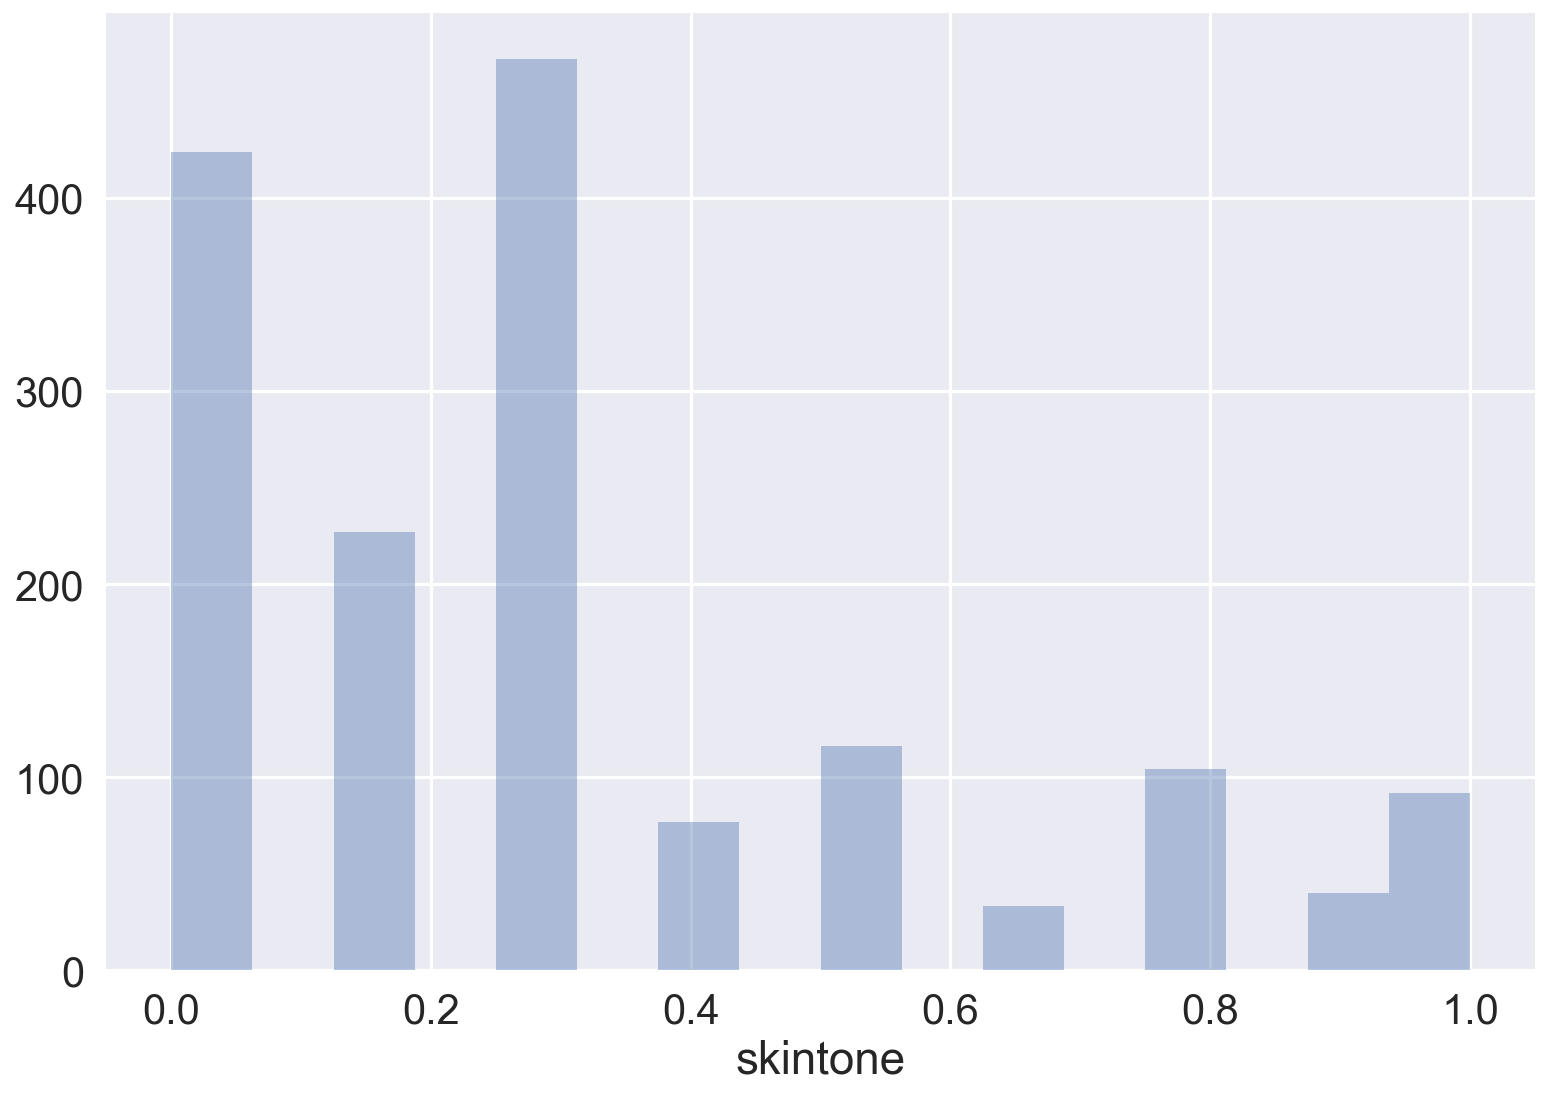

In [20]:
sns.distplot(players.skintone, kde=False);

### Positions

Might the player's position correlate with the baseline susceptibility to redcards? Likely that a defender would have a higher rate than a keeper, for example. 

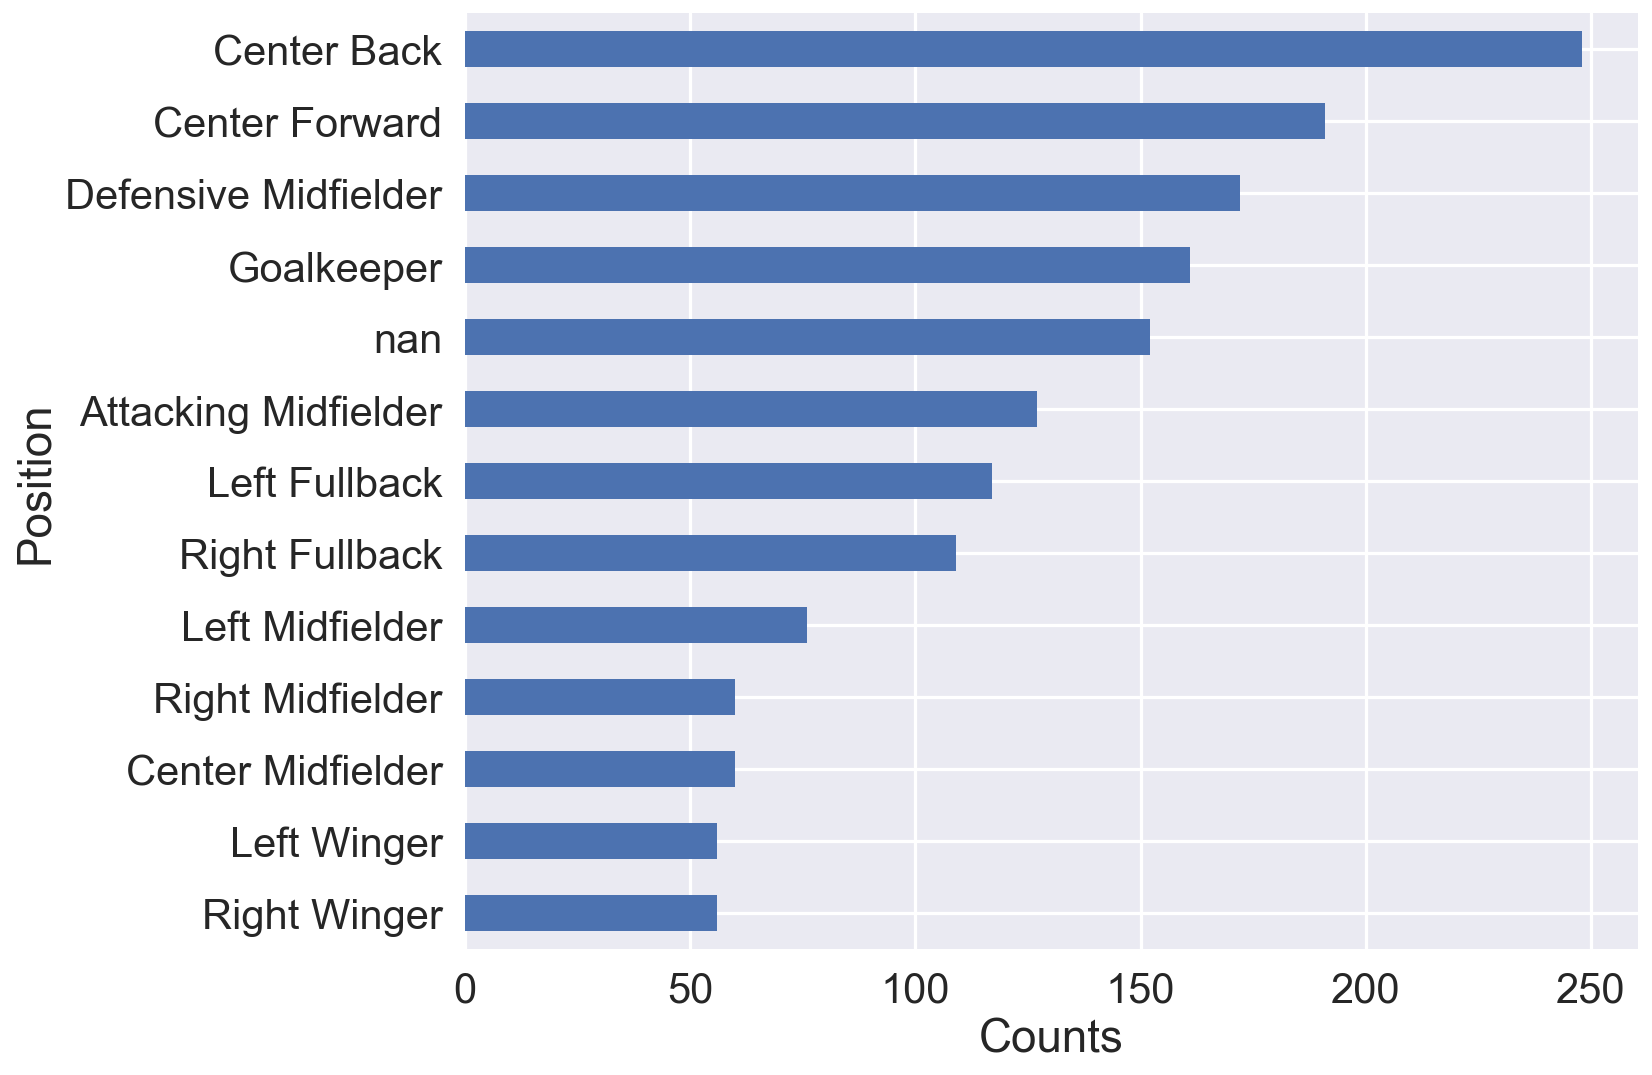

In [21]:
MIDSIZE = (12, 8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players.position.value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("Position")
ax.set_xlabel("Counts")
fig.tight_layout()

### Create higher level categories

Intuitively, the different positions in the field probably have different redcard rates, but we have data that's very granular. 

Recommendation: 

 - create a new column
 - Don't overwrite the original data in case you need it or decide later that the higher level category is not useful

I chose to split up the position types by their primary roles (you can disagree with my categorization and do it differently if you feel). 

In [22]:
position_types = players.position.unique()
position_types

array(['Center Back', 'Attacking Midfielder', 'Right Midfielder',
       'Center Midfielder', 'Goalkeeper', 'Defensive Midfielder',
       'Left Fullback', nan, 'Left Midfielder', 'Right Fullback',
       'Center Forward', 'Left Winger', 'Right Winger'], dtype=object)

In [23]:
defense = ['Center Back','Defensive Midfielder', 'Left Fullback', 'Right Fullback', ]
midfield = ['Right Midfielder', 'Center Midfielder', 'Left Midfielder',]
forward = ['Attacking Midfielder', 'Left Winger', 'Right Winger', 'Center Forward']
keeper = 'Goalkeeper'

# modifying dataframe -- adding the aggregated position categorical position_agg
players.loc[players['position'].isin(defense), 'position_agg'] = "Defense"
players.loc[players['position'].isin(midfield), 'position_agg'] = "Midfield"
players.loc[players['position'].isin(forward), 'position_agg'] = "Forward"
players.loc[players['position'].eq(keeper), 'position_agg'] = "Keeper"

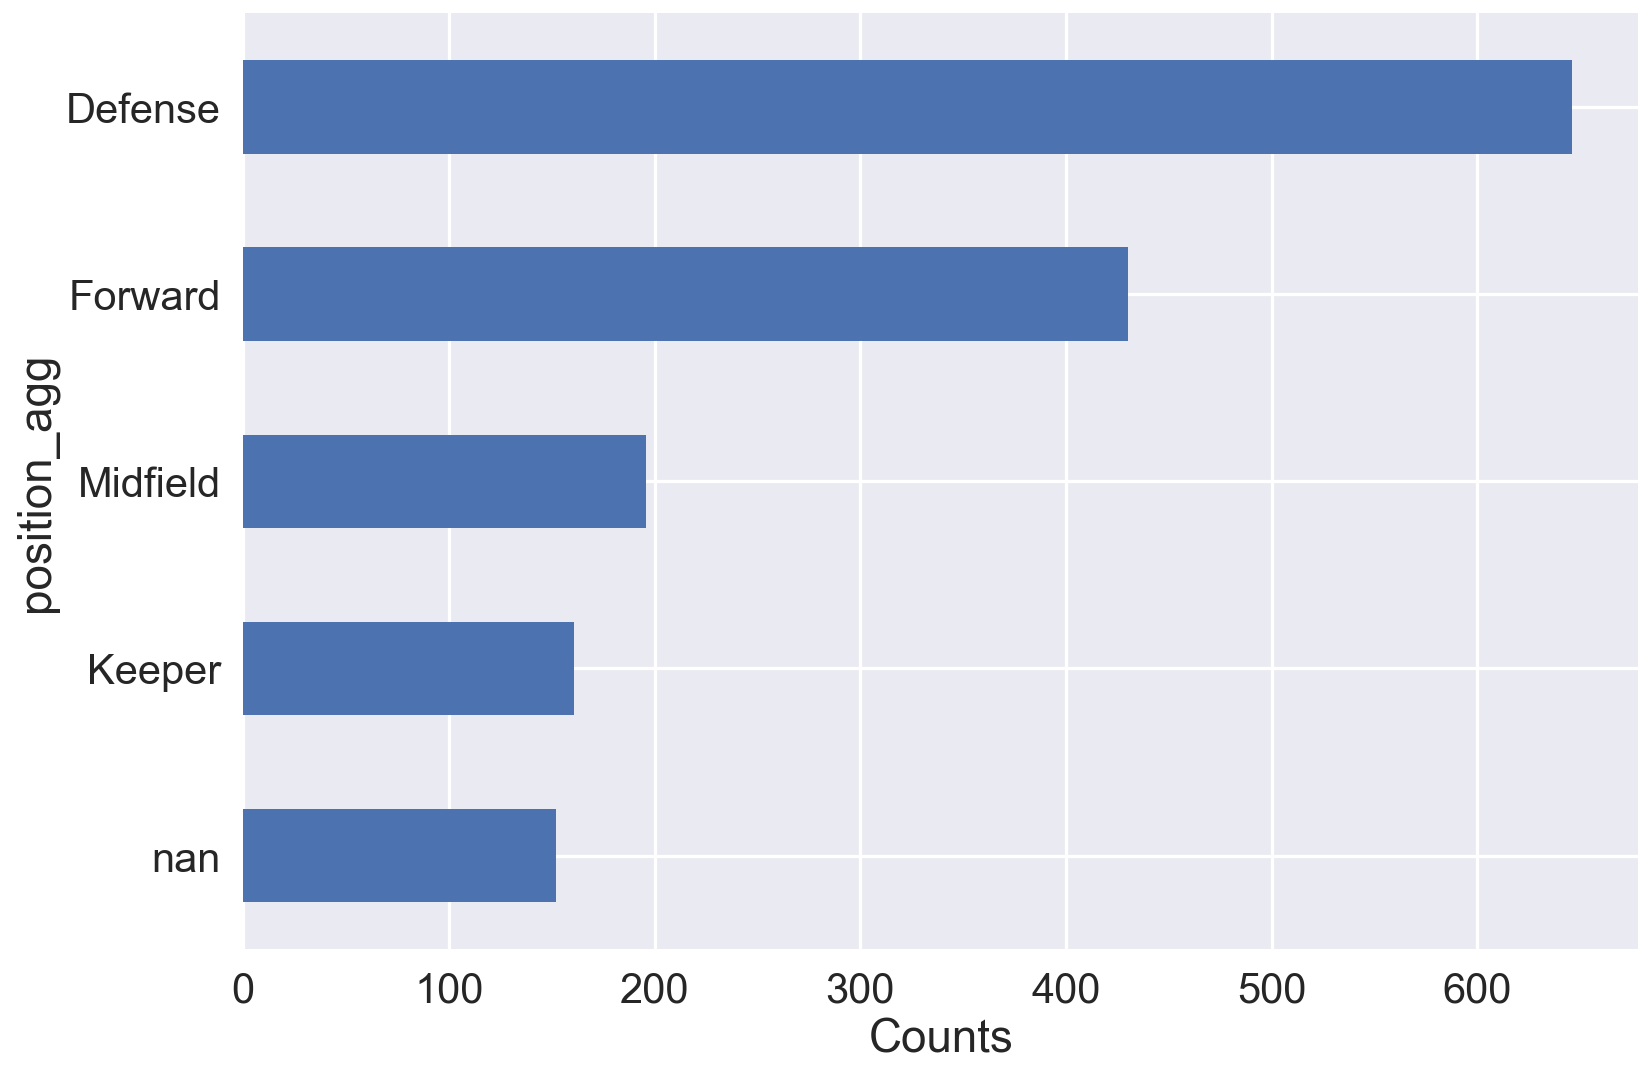

In [24]:
MIDSIZE = (12, 8)
fig, ax = plt.subplots(figsize=MIDSIZE)
players['position_agg'].value_counts(dropna=False, ascending=True).plot(kind='barh', ax=ax)
ax.set_ylabel("position_agg")
ax.set_xlabel("Counts")
fig.tight_layout()

### Height and Weight

It's possible that size might correspond with redcards. 

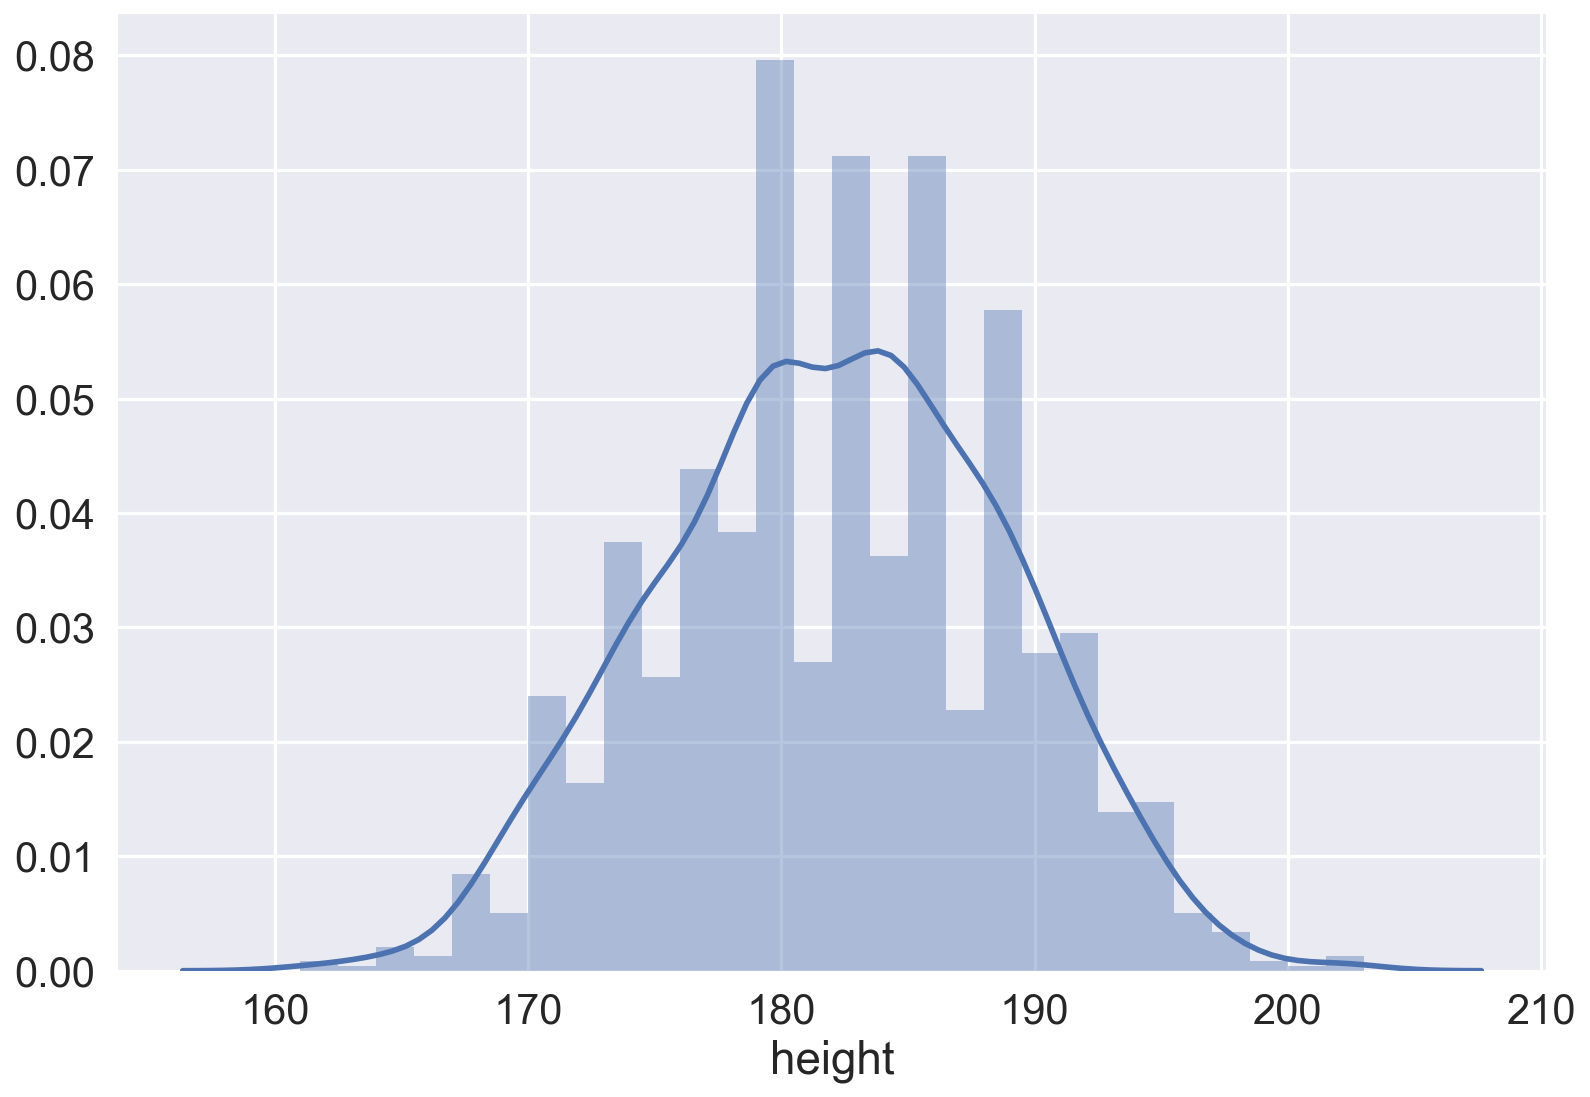

In [25]:
sns.distplot(players.height.dropna());

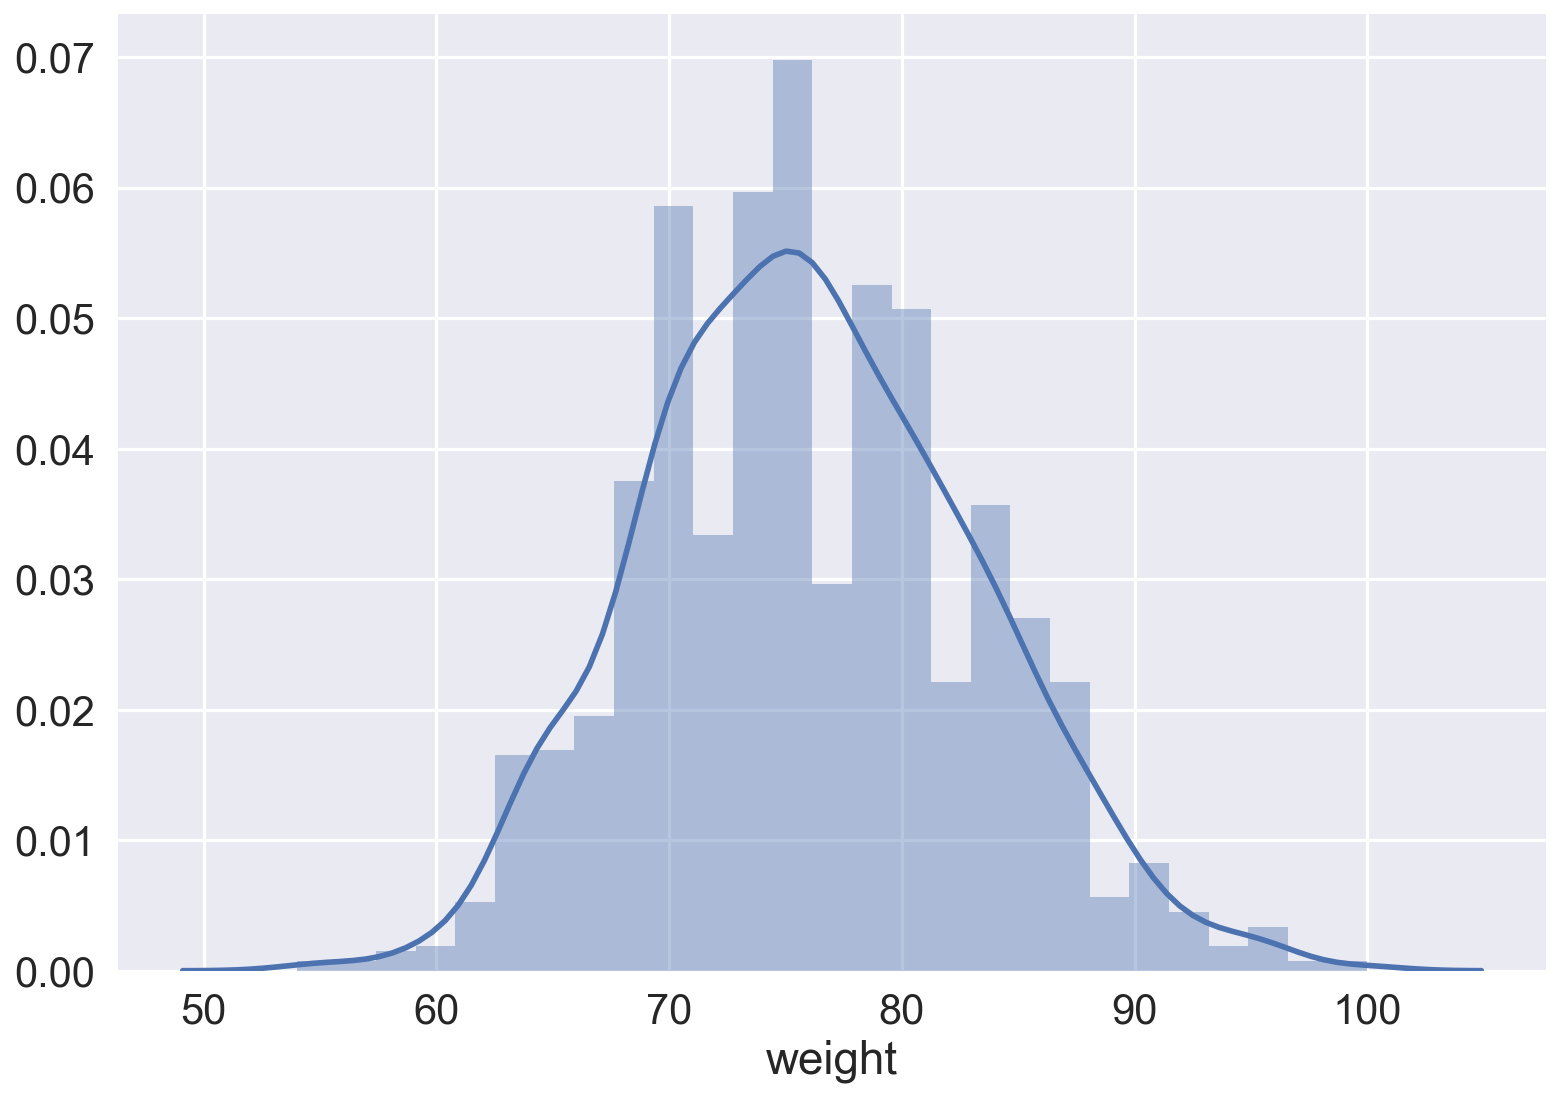

In [26]:
sns.distplot(players.weight.dropna());

## Examine pair-wise relationships

Take a look at measures that will let you quickly see if there are problems or opportunities in the data.

In [27]:
from pandas.tools.plotting import scatter_matrix

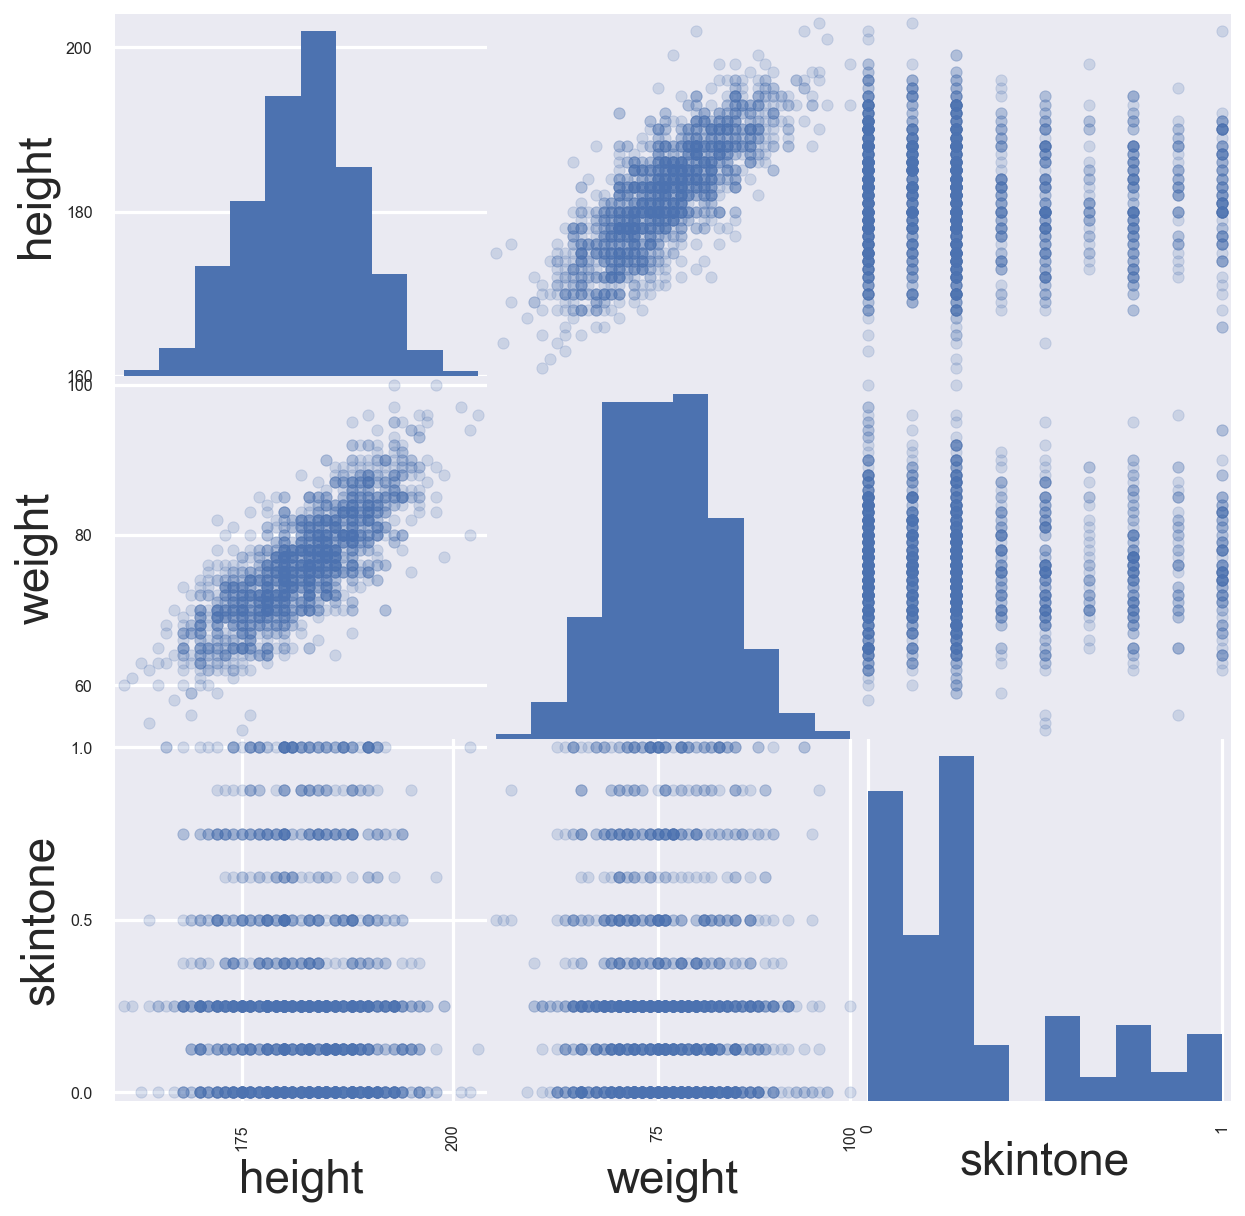

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_matrix(players[['height', 'weight', 'skintone']], alpha=0.2, diagonal='hist', ax=ax);

In [29]:
# Perhaps you want to see a particular relationship more clearly

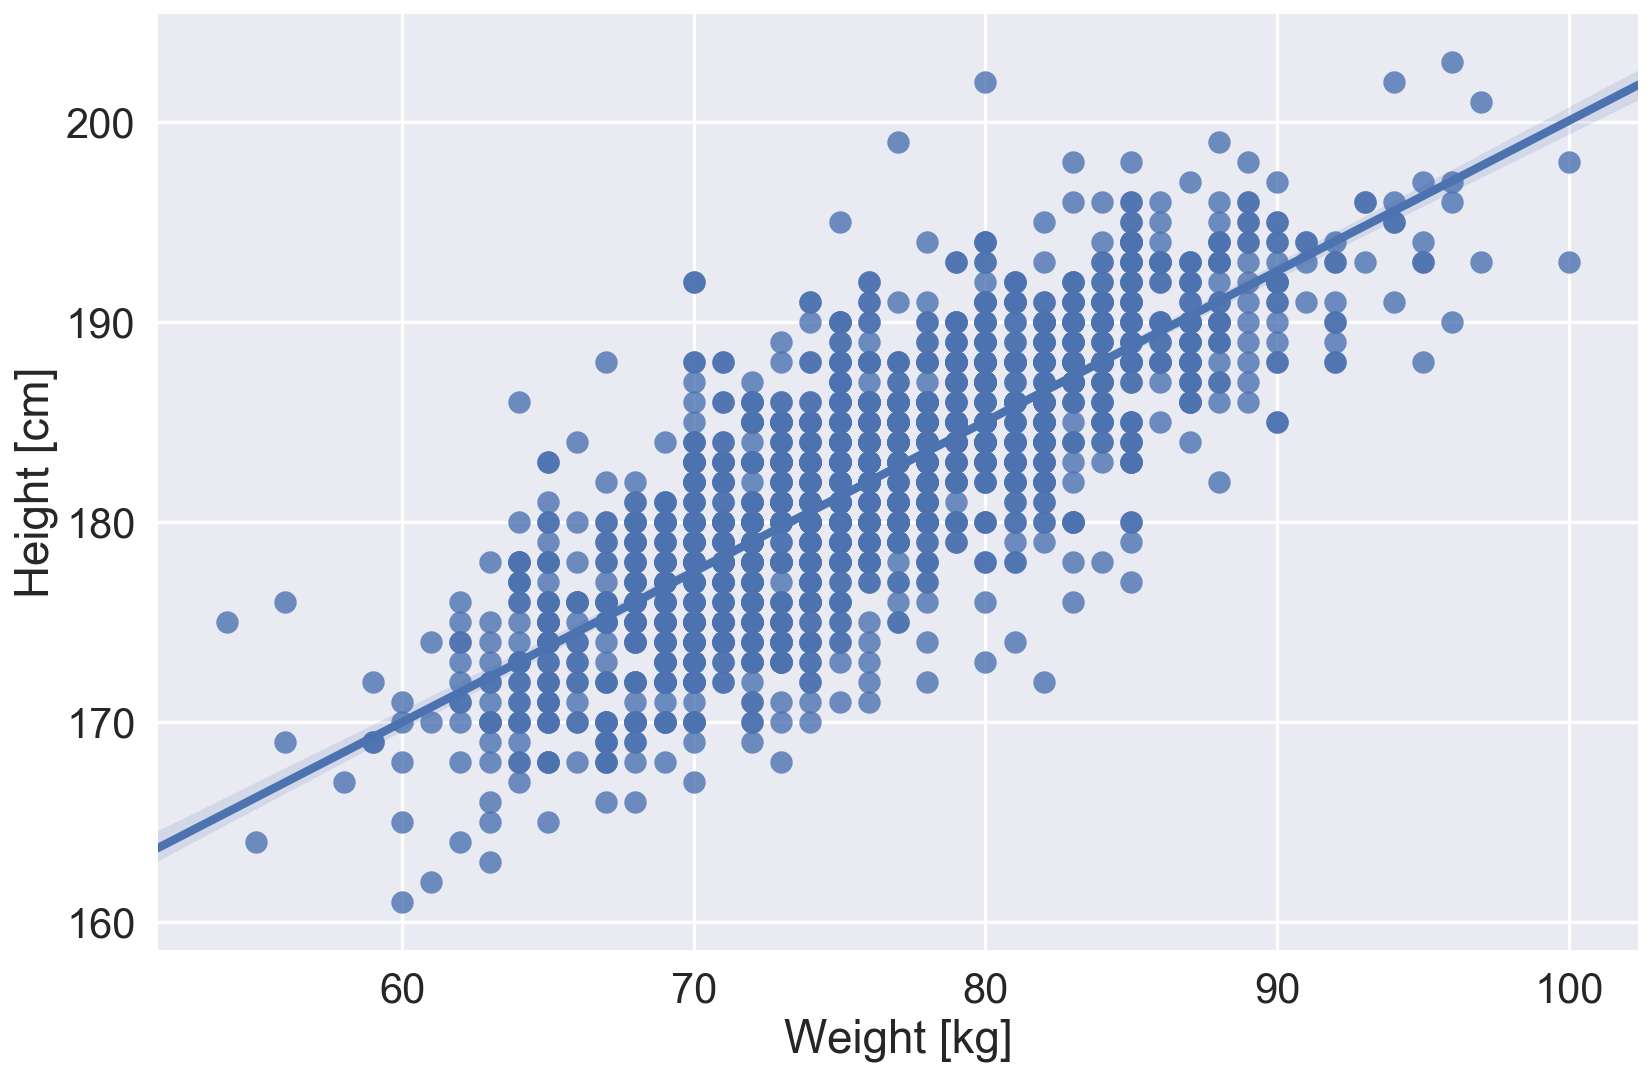

In [30]:
fig, ax = plt.subplots(figsize=MIDSIZE)
sns.regplot('weight', 'height', data=players, ax=ax)
ax.set_ylabel("Height [cm]")
ax.set_xlabel("Weight [kg]")
fig.tight_layout()

There aren't obvious outliers in the height vs weight relationship. Things that I check for: 

 - Are there zeros?
 - Are there strange correlations?
 - Are there separate clusters (something that could come from recording the height in inches for some and in cm for others, for example)?
 


## Create quantile bins for continuous variables

In [31]:
weight_categories = ["vlow_weight",
                     "low_weight",
                     "mid_weight",
                     "high_weight",
                     "vhigh_weight",
                    ]

players['weightclass'] = pd.qcut(players['weight'],
                                 len(weight_categories),
                                 weight_categories)

In [32]:
height_categories = ["vlow_height",
                     "low_height",
                     "mid_height",
                     "high_height",
                     "vhigh_height",
                    ]

players['heightclass'] = pd.qcut(players['height'],
                                 len(height_categories),
                                 height_categories)


In [33]:
players['skintoneclass'] = pd.qcut(players['skintone'], 3)

## Pandas profiling

There is a library that gives a high level overview -- https://github.com/JosPolfliet/pandas-profiling

In [34]:
pandas_profiling.ProfileReport(players)

Number of variables,13
Number of observations,1585
Total Missing (%),1.7%
Total size in memory,128.7 KiB
Average record size in memory,83.1 B
Numeric,3
Categorical,6
Date,0
Text (Unique),2
Rejected,2
Distinct count,1389


Notice a few things -- it automatically finds highly correlated features -- is that what we want? 

In this case **no** -- we want the `skintone` column, and the fact that it's highly correlated with `rater1` and `rater2`, 1, makes sense, but 2, should be consciously selected.

# Question -- What to do with birthday column?

Some points to consider: 

 - this is a career-long dataset of redcards as of 2012-2013 season
 - the age of the player at 2012 does not (necessarily) correspond to the date of receiving a redcard

In [35]:
players.birthday.head()

playerShort
aaron-hughes              08.11.1979
aaron-hunt                04.09.1986
aaron-lennon              16.04.1987
aaron-ramsey              26.12.1990
abdelhamid-el-kaoutari    17.03.1990
Name: birthday, dtype: object

In [36]:
# modifying dataframe
players['birth_date'] = pd.to_datetime(players.birthday, format='%d.%m.%Y')
players['age_years'] = ((pd.to_datetime("2013-01-01") - players['birth_date']).dt.days)/365.25

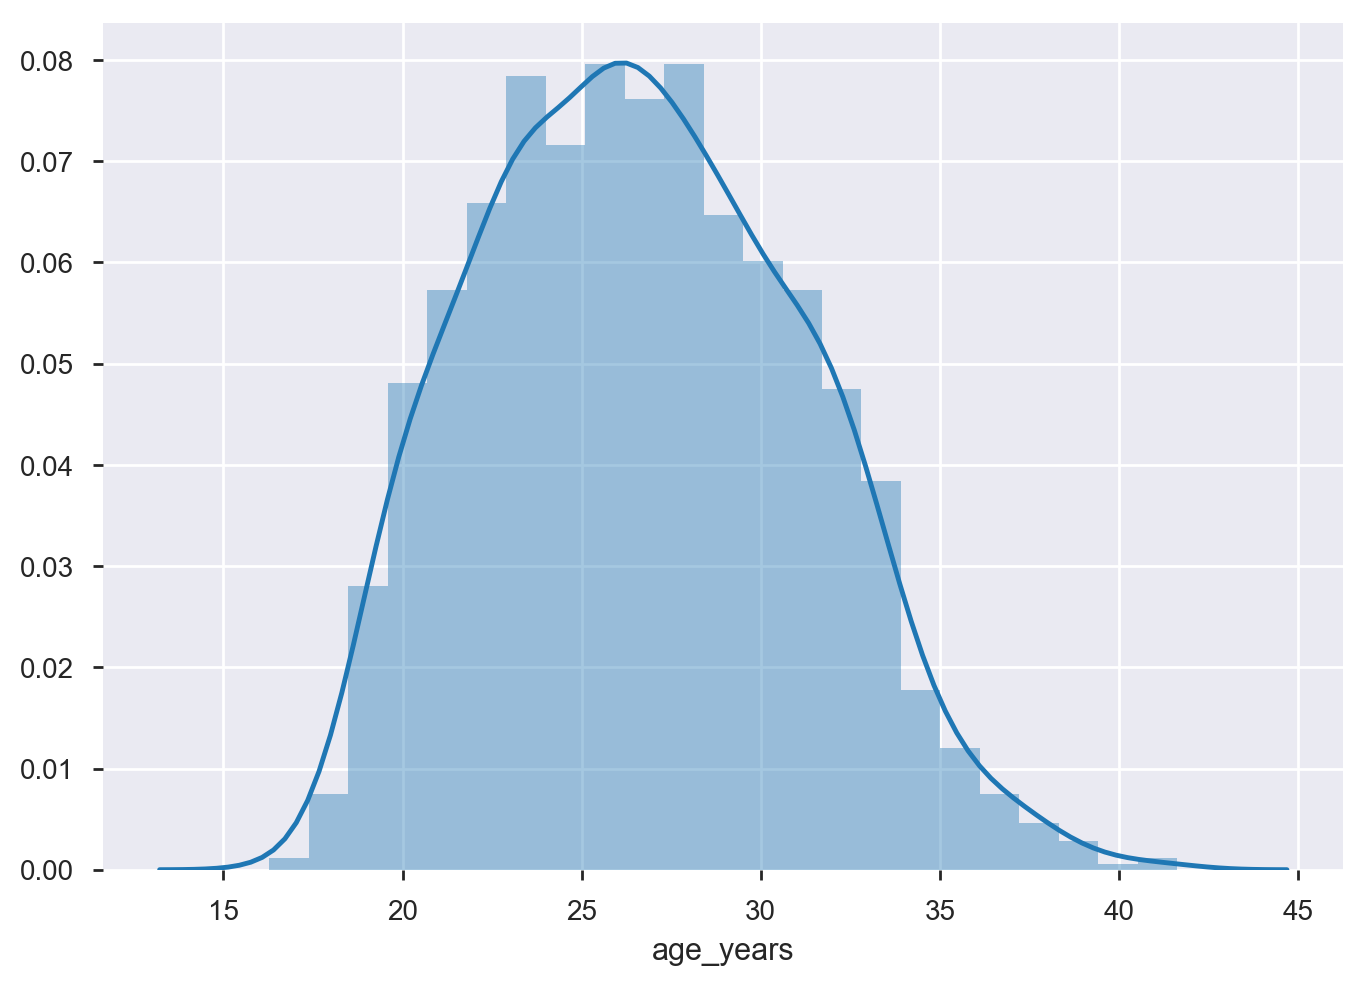

In [37]:
sns.distplot(players.age_years);

## Select variables to (possibly) use

In [38]:
players.head()

,birthday,height,weight,position,photoID,rater1,rater2,skintone,position_agg,weightclass,heightclass,skintoneclass,birth_date,age_years
playerShort,,,,,,,,,,,,,,
aaron-hughes,08.11.1979,182.0,71.0,Center Back,3868.jpg,0.25,0.00,0.125,Defense,low_weight,mid_height,"[0, 0.125]",1979-11-08,33.149897
aaron-hunt,04.09.1986,183.0,73.0,Attacking Midfielder,20136.jpg,0.00,0.25,0.125,Forward,low_weight,mid_height,"[0, 0.125]",1986-09-04,26.327173
aaron-lennon,16.04.1987,165.0,63.0,Right Midfielder,13515.jpg,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height,"(0.125, 0.25]",1987-04-16,25.713895
aaron-ramsey,26.12.1990,178.0,76.0,Center Midfielder,94953.jpg,0.00,0.00,0.000,Midfield,mid_weight,low_height,"[0, 0.125]",1990-12-26,22.017796
abdelhamid-el-kaoutari,17.03.1990,180.0,73.0,Center Back,124913.jpg,0.25,0.25,0.250,Defense,low_weight,low_height,"(0.125, 0.25]",1990-03-17,22.795346


In [39]:
players_cleaned_variables = players.columns.tolist()
players_cleaned_variables

['birthday',
 'height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'skintone',
 'position_agg',
 'weightclass',
 'heightclass',
 'skintoneclass',
 'birth_date',
 'age_years']

In [40]:
players_cleaned_variables = [#'birthday',
                             'height',
                             'weight',
#                              'position',
#                              'photoID',
#                              'rater1',
#                              'rater2',
                             'skintone',
                             'position_agg',
                             'weightclass',
                             'heightclass',
                             'skintoneclass',
#                              'birth_date',
                             'age_years']

In [41]:
pandas_profiling.ProfileReport(players[players_cleaned_variables])

Number of variables,9
Number of observations,1585
Total Missing (%),1.4%
Total size in memory,79.1 KiB
Average record size in memory,51.1 B
Numeric,4
Categorical,4
Date,0
Text (Unique),1
Rejected,0
Distinct count,1389


In [42]:
players[players_cleaned_variables].to_csv("../data/redcard/cleaned_players.csv.gz", compression='gzip')

## Challenge: Do the same process we did above but for the Referee, Clubs, and Country dataframes

In [46]:
referees.head()

,refCountry
refNum,
1,1
2,2
3,3
4,4
5,5
